# Install libraries

In [1]:
!pip install faiss-cpu datasets==2.14.0 transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0


# Import libraries

In [2]:
from functools import partial
import requests
import sys
from typing import Literal

import cv2 as cv
import datasets
from datasets import load_dataset, load_from_disk
import faiss
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import transformers
from transformers import (CLIPImageProcessor, CLIPVisionModelWithProjection,
                          BlipImageProcessor, BlipModel)


print('Python:'.ljust(16), sys.version.split('\n')[0])
print('OpenCV:'.ljust(16), cv.__version__)
print('Datasets:'.ljust(16), datasets.__version__)
print('Transformers:'.ljust(16), transformers.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Python:          3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
OpenCV:          4.8.0
Datasets:        2.14.0
Transformers:    4.31.0


# Define constants

In [3]:
# Paths
IMAGES_PATH = '/kaggle/input/coco128/coco128/images/train2017/'
WORKING_PATH = '/kaggle/working/'

# Pretrained model names (checkpoints)
CLIP_CHECKPOINT = 'openai/clip-vit-base-patch32'
BLIP_CHECKPOINT = 'Salesforce/blip-image-captioning-base'

# Load dataset

In [4]:
# Load dataset from local files
dataset = load_dataset('imagefolder', data_dir=IMAGES_PATH, split='train')

# Save dataset to disk to restore it later
dataset.save_to_disk(WORKING_PATH + 'dataset')

dataset

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 128
})

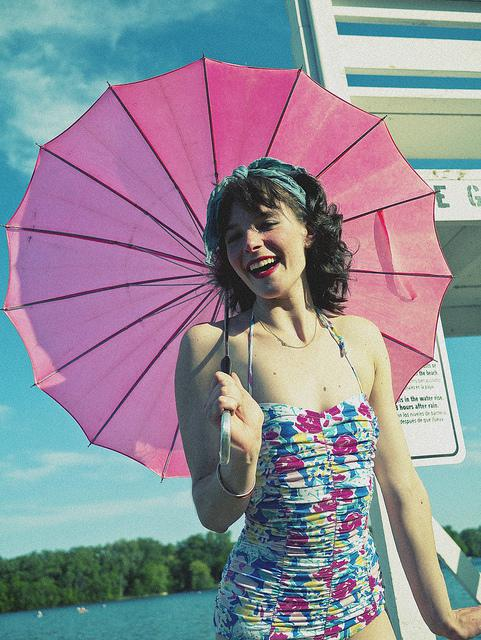

In [5]:
# Show an example
dataset[4]['image']

# Load models

In [6]:
# Load CLIP model
clip_preprocessor = CLIPImageProcessor.from_pretrained(CLIP_CHECKPOINT)
clip_model = CLIPVisionModelWithProjection.from_pretrained(CLIP_CHECKPOINT)

# Load BLIP model
blip_preprocessor = BlipImageProcessor.from_pretrained(BLIP_CHECKPOINT)
blip_model = BlipModel.from_pretrained(BLIP_CHECKPOINT)

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['text_model.encoder.layer.5.crossattention.self.value.bias', 'text_model.encoder.layer.6.attention.self.key.weight', 'text_model.encoder.layer.11.crossattention.self.value.weight', 'text_model.encoder.layer.11.crossattention.self.key.weight', 'text_model.encoder.layer.3.attention.output.dense.weight', 'text_model.encoder.layer.11.output.dense.bias', 'text_model.encoder.layer.4.attention.output.LayerNorm.weight', 'text_model.encoder.layer.11.crossattention.self.value.bias', 'text_model.encoder.layer.3.crossattention.output.dense.weight', 'text_model.encoder.layer.2.crossattention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.6.output.LayerNorm.weight', 'text_model.encoder.layer.9.attention.self.query.weight', 'text_model.encoder.layer.7.output.dense.weight', 'text_model.encoder.layer.10.int

# Compute CLIP index

In [7]:
ModelName = Literal['clip', 'blip', 'color']


def get_embedding(example, model_name: ModelName):
    # Preprocess image and get embedding
    if model_name == 'clip':
        inputs = clip_preprocessor(images=example['image'], return_tensors='pt')
        embedding = clip_model(**inputs).image_embeds.detach().numpy()
    elif model_name == 'blip':
        inputs = blip_preprocessor(images=example['image'], return_tensors='pt')
        embedding = blip_model.get_image_features(**inputs).detach().numpy()
    elif model_name == 'color':
        # Convert PIL image to OpenCV image
        image = cv.cvtColor(np.array(example['image']), cv.COLOR_RGB2BGR)
        # Resize image
        image = cv.resize(image, (2, 2), cv.INTER_AREA)
        # Convert image back to RGB
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        # Compute embedding (flatten and scale)
        embedding = (image.flatten() / 255) - 0.5
    else:
        raise Exception('Choose correct model name.')
    
    if model_name in ['clip', 'blip']:
        # Normalize embedding to use cosine similarity later
        embedding = np.squeeze(embedding)
        embedding /= np.linalg.norm(embedding)
    
    return {model_name + '_embedding': embedding}


def get_and_save_index(dataset, model_name: ModelName):
    # Get embedding
    dataset = dataset.map(partial(get_embedding, model_name=model_name))

    # Add faiss index
    if model_name in ['clip', 'blip']:
        dataset.add_faiss_index(column=model_name + '_embedding',
                                metric_type=faiss.METRIC_INNER_PRODUCT)
    elif model_name == 'color':
        dataset.add_faiss_index(column=model_name + '_embedding',
                                metric_type=faiss.METRIC_L1)
    else:
        raise Exception('Choose correct model name.')

    # Save faiss index to disk
    dataset.save_faiss_index(index_name=model_name + '_embedding',
                             file=WORKING_PATH + model_name + '_index.faiss')

In [8]:
%%time
get_and_save_index(dataset, 'clip')

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 43.3 s, sys: 1.55 s, total: 44.8 s
Wall time: 26.3 s


# Compute BLIP index

In [9]:
%%time
get_and_save_index(dataset, 'blip')

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 4min 36s, sys: 1.56 s, total: 4min 38s
Wall time: 2min 23s


# Compute index of base colors

In [10]:
%%time
get_and_save_index(dataset, 'color')

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5.7 s, sys: 1.38 s, total: 7.08 s
Wall time: 6.5 s


# Restore dataset and indexes from files

In [11]:
# Restore dataset
dataset = load_from_disk(WORKING_PATH + 'dataset')

# Restore indexes
dataset.load_faiss_index('clip_embedding', WORKING_PATH + 'clip_index.faiss')
dataset.load_faiss_index('blip_embedding', WORKING_PATH + 'blip_index.faiss')
dataset.load_faiss_index('color_embedding', WORKING_PATH + 'color_index.faiss')

# Choose a query image

In [12]:
# Choose a query image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
query_image = Image.open(requests.get(url, stream=True).raw)

# Searh with CLIP

In [13]:
def search_similar_images(query_image, model_name: ModelName):
    # Get embedding for query image
    embedding = get_embedding({'image': query_image}, model_name)[model_name + '_embedding']

    # Get top-k by cosine similarity
    scores, retrieved_examples = dataset.get_nearest_examples(model_name + '_embedding',
                                                              embedding, k=5)

    # Show query and similar images
    cols, rows = 3, 2
    figure = plt.figure(figsize=(8, 8))
    figure.add_subplot(rows, cols, 1)
    plt.title('Query image')
    plt.axis('off')
    plt.imshow(query_image)
    for i in range(5):
        figure.add_subplot(rows, cols, i + 2)
        plt.title(scores[i])
        plt.axis('off')
        plt.imshow(retrieved_examples['image'][i])
    plt.show()

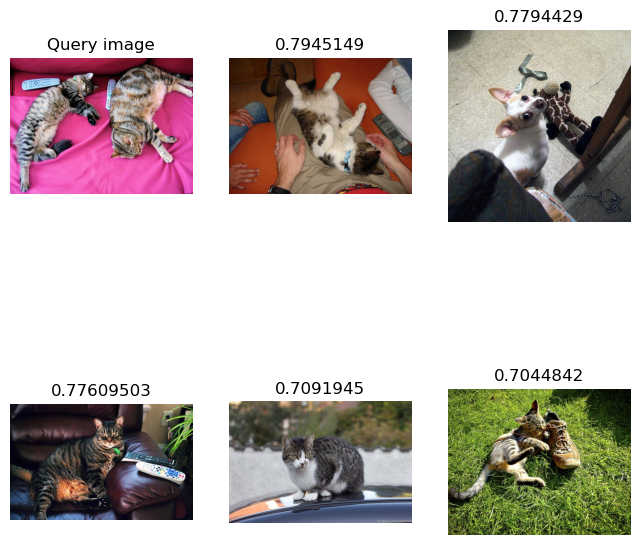

CPU times: user 1.26 s, sys: 223 ms, total: 1.48 s
Wall time: 1.01 s


In [14]:
%%time
search_similar_images(query_image, 'clip')

# Searh with BLIP

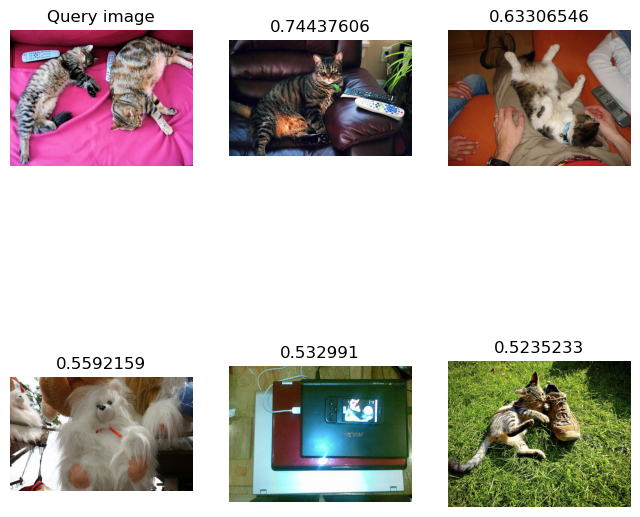

CPU times: user 2.95 s, sys: 141 ms, total: 3.1 s
Wall time: 1.83 s


In [15]:
%%time
search_similar_images(query_image, 'blip')

# Searh by base colors

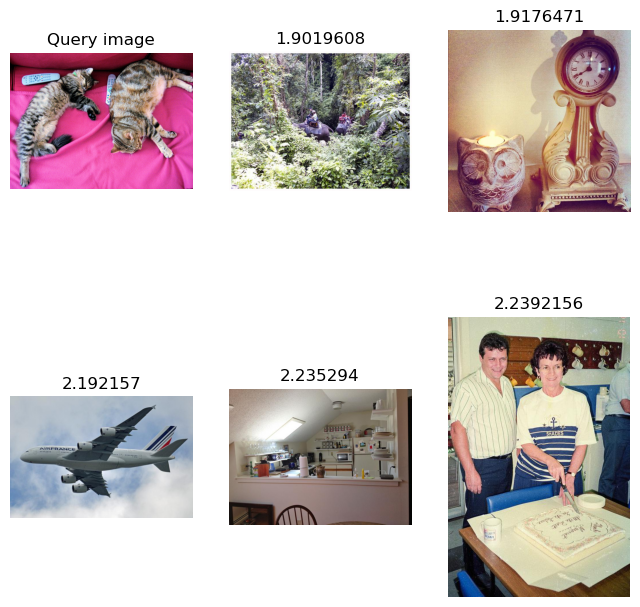

CPU times: user 1.03 s, sys: 156 ms, total: 1.19 s
Wall time: 888 ms


In [16]:
%%time
search_similar_images(query_image, 'color')

# Play with keypoints

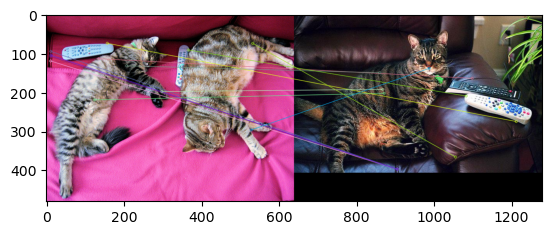

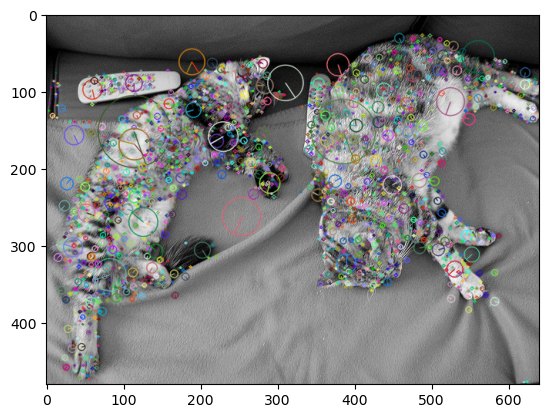

In [17]:
# Prepare two images
image1 = query_image
image2 = dataset[115]['image']

# Convert PIL images to OpenCV image
image1 = cv.cvtColor(np.array(image1), cv.COLOR_RGB2BGR)
image2 = cv.cvtColor(np.array(image2), cv.COLOR_RGB2BGR)

# Initiate SIFT detector and BFMatcher
sift = cv.SIFT_create()
bf = cv.BFMatcher()

# Convert to greyscale
gray1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Match descriptors
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append([m])
        
# Draw matches
result_image = cv.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None,
                           flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result_image = cv.cvtColor(result_image, cv.COLOR_BGR2RGB)
plt.imshow(result_image)
plt.show()

# Draw keypoints
result_image = cv.drawKeypoints(gray1, kp1, image1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(result_image)
plt.show()